In [3]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as layers
from tensorflow.keras.layers import GlobalMaxPooling2D, Activation, Dense, Conv1D, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPooling1D

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

from tensorflow.keras import optimizers
from kerastuner.tuners import RandomSearch
import itertools
from sklearn.utils import shuffle

%matplotlib inline

##########################################################
##  DATA SOURCE:
##  https://github.com/bregydoc/bcidatasetIV2a
##  http://www.bbci.de/competition/iv/desc_2a.pdf
##########################################################

resource_folder='../resources/bcidatasetIV2a/'

In [4]:
train_datas = []
#eval_datas = []
for i in range(1,9):
    train_datas.append(np.load(resource_folder+'A0'+str(i)+'T.npz'))
    
#for i in range(1,9):
#    eval_datas.append(np.load(resource_folder+'A0'+str(i)+'E.npz'))
    
primary_motor_cortex_electrodes=[7,8,9,10,11]
random_electrodes = [1,4,13,20,21]
EOG_electrodes=[22,23,24]
############################################
event_codes=[769,770,771,772]
event_names=['left','right','foot','tounge']

#event_codes=[769,770]
#event_names=['left','right']
############################################



In [5]:
X=[]
y=[]
i=0
for data in train_datas:
    signal = data['s']
    
    #REMOVE EOG
    #signal=np.delete(signal,EOG_electrodes,axis=1)
    
    #USE ONLY ELECTRODES OVER MOTOR CORTEX
    #signal = signal[:,primary_motor_cortex_electrodes]

    #USE 5 RANDOM ELECTRODES
    #signal = signal[:,random_electrodes]
        
    #FILTER BANDWIDTH
    signal=np.clip(signal,-20,20)
    signal=np.divide(signal, 20) #HASZNOS
       
    
    event_count=data['etyp'].shape[0]
    
    for x in range(event_count): 
        epos = data['epos'].T[0, x]
        edur = data['edur'].T[0, x]
        etype= data['etyp'].T[0, x]
        if edur>10:
            if int(etype) in event_codes:
                trial = signal[epos:epos+edur]
                X.append(trial)
                y.append(event_codes.index(etype))
                
    #FIRST PATIENT ONLY
    #break 
    
    #FIRST N PATINT ONLY
    #if i==4:
    #    break
    #i+=1
        
        
X=np.array(X)

y=to_categorical(np.array(y))
#############################################
#LABEL SMOOTHING
smooth_value=0.95
y*=smooth_value
smooth_min=(1-smooth_value)/(y.shape[1]-1)
y=np.where(y==0, smooth_min, y) 
#############################################
print(X.shape)
print(y.shape)


(2304, 313, 25)
(2304, 4)


In [6]:
#SHUFFLE INCLUDED
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, random_state=16)
X_val, X_test, y_val, y_test=train_test_split(X_temp, y_temp, test_size=0.5)


# IN CASE EEGNET
X_train=np.transpose(X_train,(0,2,1))
X_val=  np.transpose(X_val,(0,2,1))
X_test= np.transpose(X_test,(0,2,1))


print(X_train.shape)
print(y_train.shape)
print()
print(X_val.shape)
print(y_val.shape)
print()
print(X_test.shape)
print(y_test.shape)
print()



(2073, 25, 313)
(2073, 4)

(115, 25, 313)
(115, 4)

(116, 25, 313)
(116, 4)



In [7]:
def EEGNet(hp, nb_classes=4, Chans = 25, Samples = 313, 
             dropoutRate = 0.5, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25):    

    kernLength = hp.Int('kernelLength',
                       min_value = 5,
                       max_value = 155,
                       step=10)
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
  
    block1       = Dropout(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)

    block2       = Dropout(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    model = Model(inputs=input1, outputs=softmax)
    opt = keras.optimizers.Adam(lr=0.005)
    model.compile(optimizer=opt,
          #loss='binary_crossentropy',
          loss='categorical_crossentropy',
          metrics=['accuracy']
         )

    return model

In [8]:
def scheduler(epoch, lr):
    if epoch < 60:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [9]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

tuner = RandomSearch(
    EEGNet,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=3,
    directory='kernel_search',
    project_name='kernel_search')
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project kernel_search\kernel_search\oracle.json
INFO:tensorflow:Reloading Tuner from kernel_search\kernel_search\tuner0.json
Search space summary
Default search space size: 1
kernelLength (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 155, 'step': 10, 'sampling': None}


In [10]:
tuner.search(X_train,
             y_train,
             validation_data=(X_val, y_val),
             batch_size=32,
             epochs=100,
             shuffle=True,
             callbacks=[callback])


INFO:tensorflow:Oracle triggered exit


In [11]:
tuner.results_summary()

Results summary
Results in kernel_search\kernel_search
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
kernelLength: 115
Score: 0.6853651801745096
Trial summary
Hyperparameters:
kernelLength: 145
Score: 0.6885085701942444
Trial summary
Hyperparameters:
kernelLength: 135
Score: 0.6906039913495382
Trial summary
Hyperparameters:
kernelLength: 125
Score: 0.6932589014371237
Trial summary
Hyperparameters:
kernelLength: 45
Score: 0.6969151894251505
Trial summary
Hyperparameters:
kernelLength: 155
Score: 0.6988972822825114
Trial summary
Hyperparameters:
kernelLength: 75
Score: 0.7001622517903646
Trial summary
Hyperparameters:
kernelLength: 95
Score: 0.7036732236544291
Trial summary
Hyperparameters:
kernelLength: 55
Score: 0.7095418175061544
Trial summary
Hyperparameters:
kernelLength: 85
Score: 0.7146231333414713


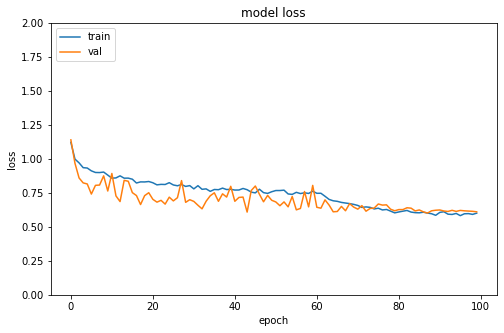

In [13]:
plt.rcParams["figure.figsize"] = [8, 5]
plt.ylim([0, 2])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

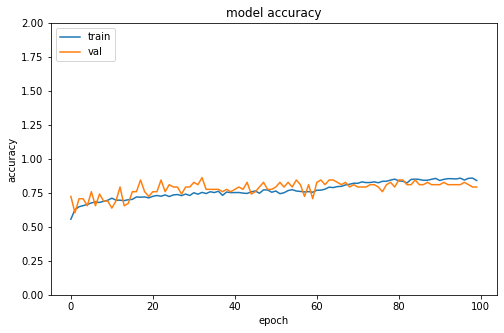

In [14]:
plt.ylim([0, 2])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## PREDICT

In [15]:
summ, correct, incorrect = 0, 0, 0

for i in range(len(X_test)):
    #print(y_test[i])
    #gt = np.where(y_test[i]== 1)[0][0]
    gt = np.where(y_test[i]>0.5)[0][0]

    #print(gt)
    input_data=X_test[i]
    #print("#################")
    #print(input_data.shape)
    
    #Doesn't matter?
    input_data=np.expand_dims(input_data, axis=0)
    
    #print(input_data.shape)
    input_data=np.expand_dims(input_data, axis = -1)
    #print(input_data.shape)

    
    #print("#################")
    #print(input_data.shape)
    result = model.predict(input_data)[0]
    #print(result)
    prediction = np.where(result == np.amax(result))[0][0]
    #print(prediction)
    summ+=1
    if gt==prediction:
        correct+=1
    else:
        incorrect+=1
    #print()
print("SUMM:{} | correct: {} | incorrect: {}".format(summ, correct, incorrect))
print("Accuracy: {}%".format(round((correct/summ)*100,2)))


SUMM:58 | correct: 50 | incorrect: 8
Accuracy: 86.21%


In [14]:
!nvidia-smi

Tue May 11 16:56:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.92       Driver Version: 461.92       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 106... WDDM  | 00000000:01:00.0 Off |                  N/A |
|  0%   45C    P8     6W / 120W |    238MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 106... WDDM  | 00000000:03:00.0  On |                  N/A |
| 41%   

In [2]:
!jt -t oceans16 -T